This cell imports all the necessary libraries. We use packages for data handling (pandas, numpy), visualization (matplotlib), financial data retrieval (yfinance), data preprocessing (MinMaxScaler), machine learning (RandomForestRegressor, TimeSeriesSplit, mean_squared_error), and deep learning (TensorFlow/Keras for building an LSTM model).

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


Download hourly data for Upstart Holdings (UPST) for the past 240 days with a 60-minute interval. The code resets the index, forward-fills any missing values, and sorts the data by the 'Datetime' column (which is specific to intraday data).

In [2]:
# Download hourly data for UPST
ticker = "UPST"
data = yf.download(ticker, period="240d", interval="60m")
data.reset_index(inplace=True)

# Forward fill missing values and ensure the data is sorted by datetime
data.fillna(method='ffill', inplace=True)
data.sort_values('Datetime', inplace=True)  # 'Datetime' column exists for intraday data


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
<ipython-input-2-7774c159f16b>:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


Defines helper functions to compute technical indicators such as the Simple Moving Average (SMA) and Relative Strength Index (RSI). Then generates these features using window sizes appropriate for hourly data and creates a lagged target variable (the next hour’s closing price). Finally, the selected columns are scaled using MinMaxScaler.

In [3]:
def compute_sma(series, window):
    """Compute Simple Moving Average (SMA)."""
    return series.rolling(window=window).mean()

def compute_rsi(series, window=14):
    """Compute Relative Strength Index (RSI)."""
    delta = series.diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    ma_up = up.rolling(window=window).mean()
    ma_down = down.rolling(window=window).mean()
    rsi = 100 - (100 / (1 + ma_up / ma_down))
    return rsi

def generate_features(df):
    """Generate technical indicator features."""
    df['SMA_20'] = compute_sma(df['Close'], window=20)
    df['RSI_14'] = compute_rsi(df['Close'], window=14)
    df.dropna(inplace=True)  # Drop rows with NaN values resulting from indicator calculations
    return df

def create_lag_features(df, lag=1):
    """Create lag features for forecasting the next hour's closing price."""
    df['Target'] = df['Close'].shift(-lag)  # Next hour close as target
    df.dropna(inplace=True)
    return df

# Apply feature engineering functions
data = generate_features(data)
data = create_lag_features(data, lag=1)

# Scale the selected columns using MinMaxScaler
scaler = MinMaxScaler()
cols_to_scale = ['Close', 'SMA_20', 'RSI_14', 'Target']
data[cols_to_scale] = scaler.fit_transform(data[cols_to_scale])


Prepares the data for a baseline model using a RandomForestRegressor. Uses a TimeSeriesSplit to mimic real trading conditions for hourly data. The model is trained and evaluated over multiple folds, with the Mean Squared Error (MSE) printed for each fold.

In [4]:
# Prepare features and target for the baseline model
features = ['Close', 'SMA_20', 'RSI_14']
target = 'Target'
X = data[features].values
y = data[target].values

# Use TimeSeriesSplit to mimic real trading conditions
tscv = TimeSeriesSplit(n_splits=10)
rf_predictions = np.zeros(len(y))
fold = 1
print("RandomForest Baseline Performance (Hourly Data):")
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Initialize and train the RandomForestRegressor
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    rf_predictions[test_index] = y_pred
    mse = mean_squared_error(y_test, y_pred)
    print(f"  Fold {fold} MSE: {mse:.5f}")
    fold += 1


RandomForest Baseline Performance (Hourly Data):
  Fold 1 MSE: 0.00012
  Fold 2 MSE: 0.00003
  Fold 3 MSE: 0.00012
  Fold 4 MSE: 0.00153
  Fold 5 MSE: 0.00231
  Fold 6 MSE: 0.00242
  Fold 7 MSE: 0.01787
  Fold 8 MSE: 0.00560
  Fold 9 MSE: 0.00689
  Fold 10 MSE: 0.00148


Builds an LSTM-based deep learning model for regression using hourly data. We first define functions to prepare sequential data and build the LSTM model. The dataset is split into training and testing sets (80/20 split), the model is trained using early stopping, and finally, its performance is evaluated using MSE.

In [5]:
def prepare_lstm_data(df, feature_columns, target_column, sequence_length=60):
    """
    Prepare the dataset for LSTM by creating sequences of fixed length.
    Each sequence consists of multiple hourly observations.
    """
    X_seq, y_seq = [], []
    data_values = df[feature_columns + [target_column]].values
    for i in range(len(data_values) - sequence_length):
        X_seq.append(data_values[i:i+sequence_length, :-1])
        y_seq.append(data_values[i+sequence_length - 1, -1])
    return np.array(X_seq), np.array(y_seq)

def build_lstm_model(input_shape):
    """Build and compile an LSTM model for regression."""
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(50))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Set sequence length and define feature/target columns for LSTM
sequence_length = 60  # use 60 past hourly observations to predict the next hour
feature_columns = ['Close', 'SMA_20', 'RSI_14']
target_column = 'Target'

# Prepare LSTM dataset
X_lstm, y_lstm = prepare_lstm_data(data, feature_columns, target_column, sequence_length)

# Split LSTM data into training and testing sets (80/20 split)
split_index = int(len(X_lstm) * 0.8)
X_train_lstm, X_test_lstm = X_lstm[:split_index], X_lstm[split_index:]
y_train_lstm, y_test_lstm = y_lstm[:split_index], y_lstm[split_index:]

# Build and train the LSTM model
input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])
lstm_model = build_lstm_model(input_shape)
early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
history = lstm_model.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=32, verbose=1, callbacks=[early_stop])

# Evaluate LSTM model performance
y_pred_lstm = lstm_model.predict(X_test_lstm)
lstm_mse = mean_squared_error(y_test_lstm, y_pred_lstm)
print(f"LSTM Test MSE (Hourly Data): {lstm_mse:.5f}")


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0433
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0032
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0026
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0028
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0018
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0021
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.0020
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.0022
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0025
Epoch 10/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0017
Epoch 11/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0014
Epoch 12/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0017
Epoch 13/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 0.0016
Epoch 14/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0019
Epoch 15/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0015
Epoch 16/50
40/

Since the features were scaled to the range [0, 1], we convert both the predictions and actual values back to their original scale. The inverse transformation uses the minimum and maximum values from the "Target" column in the scaling process.

In [6]:
# We extract the min and max for the 'Target' (which is the next hour's 'Close').
target_min = scaler.data_min_[3]
target_max = scaler.data_max_[3]

def inverse_transform(scaled_value):
    """Convert a scaled value back to the original price scale."""
    return scaled_value * (target_max - target_min) + target_min

actual_y = inverse_transform(y)
actual_rf_predictions = inverse_transform(rf_predictions)
actual_lstm_predictions = inverse_transform(y_pred_lstm.flatten())


This section creates two plots:

The first plot shows the RandomForest predictions versus the actual hourly closing prices.
The second plot shows the LSTM predictions versus the actual hourly closing prices.

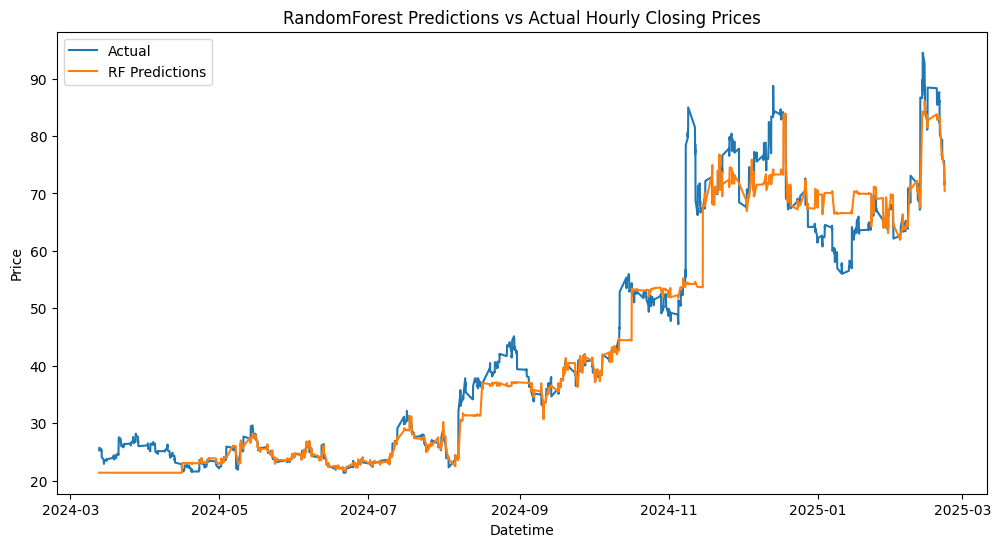

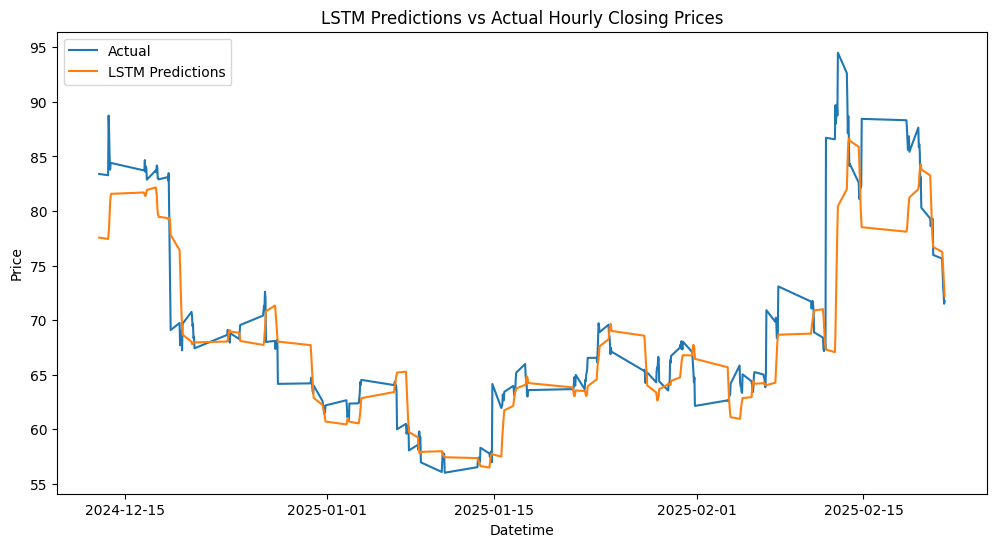

In [7]:
# Plot RandomForest predictions vs. actual prices
plt.figure(figsize=(12, 6))
plt.plot(data['Datetime'], actual_y, label="Actual")
plt.plot(data['Datetime'], actual_rf_predictions, label="RF Predictions")
plt.xlabel("Datetime")
plt.ylabel("Price")
plt.title("RandomForest Predictions vs Actual Hourly Closing Prices")
plt.legend()
plt.show()

# Plot LSTM predictions vs. actual prices
test_datetimes = data['Datetime'].iloc[-len(actual_lstm_predictions):]
plt.figure(figsize=(12, 6))
plt.plot(test_datetimes, actual_y[-len(actual_lstm_predictions):], label="Actual")
plt.plot(test_datetimes, actual_lstm_predictions, label="LSTM Predictions")
plt.xlabel("Datetime")
plt.ylabel("Price")
plt.title("LSTM Predictions vs Actual Hourly Closing Prices")
plt.legend()
plt.show()


Finally, this cell forecasts future prices for the next few hours using both models:

RandomForest: The model iteratively predicts the next hour by updating the 'Close' feature with the latest prediction.

LSTM: The model uses the last available sequence of data to iteratively forecast the next hour’s price by updating the sequence. The predicted values are then converted back to the actual price scale.

In [8]:
# For RandomForest: Iteratively forecast the next N hours (e.g., next 72 hours)
n_hours = 72
last_row = data.iloc[-1].copy()
future_predictions_rf = []
current_features = last_row[features].values.reshape(1, -1)

for i in range(n_hours):
    pred_scaled = rf_model.predict(current_features)[0]
    pred_actual = inverse_transform(pred_scaled)
    future_predictions_rf.append(pred_actual)
    # Update the 'Close' feature to the predicted scaled value (keeping SMA and RSI unchanged)
    current_features[0, 0] = pred_scaled

print(f"RandomForest Future Predictions (Actual Price) for next {n_hours} hours:", future_predictions_rf)

# For LSTM: Iteratively forecast the next N hours using the last available sequence
last_sequence = data[feature_columns + [target_column]].values[-sequence_length:]
future_predictions_lstm = []
current_sequence = last_sequence.copy()

for i in range(n_hours):
    input_seq = current_sequence[:, :-1].reshape(1, sequence_length, len(feature_columns))
    pred_scaled = lstm_model.predict(input_seq)[0, 0]
    pred_actual = inverse_transform(pred_scaled)
    future_predictions_lstm.append(pred_actual)
    # Create a new row by updating the last row in the sequence with the predicted value
    new_row = current_sequence[-1].copy()
    new_row[0] = pred_scaled  # update 'Close'
    new_row[-1] = pred_scaled  # update 'Target'
    current_sequence = np.vstack([current_sequence[1:], new_row])

print(f"LSTM Future Predictions (Actual Price) for next {n_hours} hours:", future_predictions_lstm)


RandomForest Future Predictions (Actual Price) for next 72 hours: [70.40470497131349, 69.83843803405762, 69.59686790466313, 68.71915054321295, 68.833500289917, 68.54298477172853, 68.83440269470213, 68.54298477172853, 68.83440269470213, 68.54298477172853, 68.83440269470213, 68.54298477172853, 68.83440269470213, 68.54298477172853, 68.83440269470213, 68.54298477172853, 68.83440269470213, 68.54298477172853, 68.83440269470213, 68.54298477172853, 68.83440269470213, 68.54298477172853, 68.83440269470213, 68.54298477172853, 68.83440269470213, 68.54298477172853, 68.83440269470213, 68.54298477172853, 68.83440269470213, 68.54298477172853, 68.83440269470213, 68.54298477172853, 68.83440269470213, 68.54298477172853, 68.83440269470213, 68.54298477172853, 68.83440269470213, 68.54298477172853, 68.83440269470213, 68.54298477172853, 68.83440269470213, 68.54298477172853, 68.83440269470213, 68.54298477172853, 68.83440269470213, 68.54298477172853, 68.83440269470213, 68.54298477172853, 68.83440269470213, 68.5